In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import folium
import os
from pathlib import Path
from shapely import wkt
from shapely.geometry import Point, Polygon, MultiPolygon
import shapely
import random
import inrix_data_science_utils.maps.quadkey as qkey
from inrix_data_science_utils.maps import get_distance_km, get_initial_bearing
import time

# set cwd to src
os.chdir('../src')
from utils import *  # add_qks_to_map, add_trips_to_map, poly_to_qkeys

data_path = Path('../data')

## Look at the ratio of dest/orig over time and compare this to ground truth occupancy

In [3]:
# Load the trip data
dest_filepath = data_path / 'dest_trips_IrvineSpectrumCenter_2022-11-01_to_2023-03-31.csv'
orig_filepath = data_path / 'orig_trips_IrvineSpectrumCenter_2022-11-01_to_2023-03-31.csv'
dest_trips = pd.read_csv(dest_filepath)
orig_trips = pd.read_csv(orig_filepath)

# timestamp
dest_trips['timestamp'] = pd.to_datetime(dest_trips[['year', 'month', 'day', 'hour', 'minute', 'second']])
orig_trips['timestamp'] = pd.to_datetime(orig_trips[['year', 'month', 'day', 'hour', 'minute', 'second']])
dest_trips = dest_trips.drop(columns=['start_time', 'year', 'month', 'day', 'hour', 'minute'])
orig_trips = orig_trips.drop(columns=['start_time', 'year', 'month', 'day', 'hour', 'minute'])
dest_trips['timestamp'] = dest_trips['timestamp'].dt.tz_localize('UTC').dt.tz_convert('US/Pacific')
orig_trips['timestamp'] = orig_trips['timestamp'].dt.tz_localize('UTC').dt.tz_convert('US/Pacific')

# geometry
dest_trips['geometry'] = dest_trips.apply(lambda row: Point(row['end_lon'], row['end_lat']), axis=1)
orig_trips['geometry'] = orig_trips.apply(lambda row: Point(row['start_lon'], row['start_lat']), axis=1)
dest_trips = gpd.GeoDataFrame(dest_trips, geometry='geometry')
orig_trips = gpd.GeoDataFrame(orig_trips, geometry='geometry')

# load the parking lot data
parking_lot_filepath = data_path / 'IrvineSpectrumCenter_parking.csv'
parking_lots = pd.read_csv(parking_lot_filepath)
parking_lots = parking_lots.groupby('pk_lot').first().reset_index()
parking_lots = parking_lots[['pk_lot', 'geometry']]
parking_lots['geometry'] = parking_lots['geometry'].apply(wkt.loads)
parking_lots = gpd.GeoDataFrame(parking_lots, geometry='geometry')

# filter out airport lots
east = lambda poly: poly.centroid.x > -117.84
parking_lots = parking_lots[parking_lots['geometry'].apply(east)]
lot_ids = list(parking_lots['pk_lot'].unique())


# filter trips to be in the parking lot
dest_trips = gpd.sjoin(dest_trips, parking_lots, how='inner', predicate='within')
orig_trips = gpd.sjoin(orig_trips, parking_lots, how='inner', predicate='within')
irrelevant_cols = ['count', 'is_moving', 'index_right']
dest_trips = dest_trips.drop(columns=irrelevant_cols)
orig_trips = orig_trips.drop(columns=irrelevant_cols)

dest_trips.head(1)
orig_trips.head(1)

,second,orig_qk17,dest_qk17,start_lat,start_lon,end_lat,end_lon,trip_id,timestamp,geometry,pk_lot
1,11,2301320210201011,2301320212010310,33.650893,-117.741683,33.568317,-117.71187,06a3643dc8952ac517fa1a339350d45d,2022-11-08 13:10:11-08:00,POINT (-117.74168 33.65089),381380


Number of destinations: 55690
Number of origins: 54835


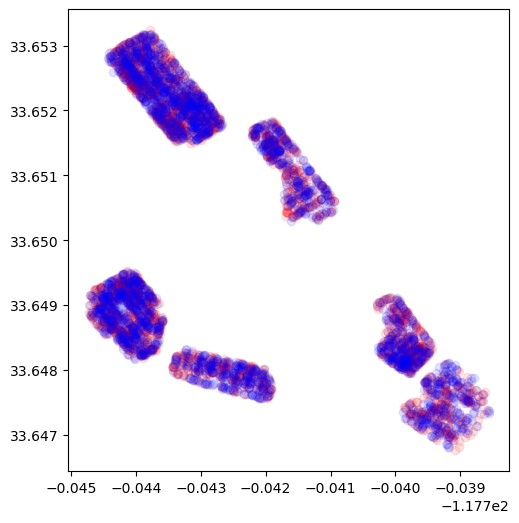

In [4]:
print(f'Number of destinations: {len(dest_trips)}')
print(f'Number of origins: {len(orig_trips)}')

fig = plt.figure(figsize=(6, 6))
N = 20
dest_trips[::N].plot(ax=plt.gca(), color='red', alpha=0.1)
orig_trips[::N].plot(ax=plt.gca(), color='blue', alpha=0.1)
plt.show()

Let's be sure that there is no bias between lot and standard ratio

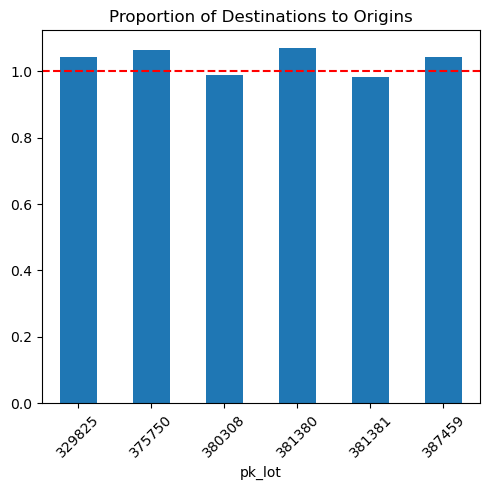

In [12]:
dest_counts = dest_trips.groupby('pk_lot').size()
orig_counts = orig_trips.groupby('pk_lot').size()
prop = dest_counts / orig_counts

fig = plt.figure(figsize=(5, 5))
prop.plot(kind='bar', ax=plt.gca())
plt.axhline(y=1, color='r', linestyle='--')
plt.xticks(rotation=45)
plt.title('Proportion of Destinations to Origins')
plt.tight_layout()
plt.show()



Compare the in_out_ratio with actual parking lot occupancy

In [6]:
# group by hour and get the in/out ratio
dest_trips['nearest_hour'] = dest_trips['timestamp'].dt.round('h', ambiguous='NaT', nonexistent='NaT')
orig_trips['nearest_hour'] = orig_trips['timestamp'].dt.round('h', ambiguous='NaT', nonexistent='NaT')
# drop NaT
dest_trips = dest_trips.dropna(subset=['nearest_hour'])
orig_trips = orig_trips.dropna(subset=['nearest_hour'])
dest_counts = dest_trips.groupby(['nearest_hour', 'pk_lot']).size().reset_index()
orig_counts = orig_trips.groupby(['nearest_hour', 'pk_lot']).size().reset_index()
dest_counts = dest_counts.rename(columns={0: 'dest_count'})
orig_counts = orig_counts.rename(columns={0: 'orig_count'})

hour_df = dest_counts.merge(orig_counts, on=['nearest_hour', 'pk_lot'], how='inner')
hour_df = hour_df.sort_values(by='nearest_hour')
hour_df['in_out_ratio'] = hour_df['dest_count'] / hour_df['orig_count']
hour_df

,nearest_hour,pk_lot,dest_count,orig_count,in_out_ratio
0,2022-10-31 17:00:00-07:00,375750,3,4,0.750000
1,2022-10-31 17:00:00-07:00,381381,1,5,0.200000
2,2022-10-31 17:00:00-07:00,387459,2,1,2.000000
3,2022-10-31 18:00:00-07:00,329825,2,3,0.666667
4,2022-10-31 18:00:00-07:00,375750,4,3,1.333333
...,...,...,...,...,...
10078,2023-03-30 17:00:00-07:00,380308,8,1,8.000000
10079,2023-03-30 17:00:00-07:00,381380,2,1,2.000000
10076,2023-03-30 17:00:00-07:00,329825,2,4,0.500000
10077,2023-03-30 17:00:00-07:00,375750,5,1,5.000000


In [7]:
parking_occupancy = pd.read_csv('../data/parking_Irvine_2022-11-01_2023-03-31.csv')
parking_occupancy['dt_start_date'] = pd.to_datetime(parking_occupancy['dt_start_date'])
parking_occupancy['dt_start_date'] = parking_occupancy['dt_start_date'].dt.tz_convert('US/Pacific')
parking_occupancy['geometry'] = parking_occupancy['geometry'].apply(lambda x: wkt.loads(x))
east = lambda poly: poly.centroid.x > -117.84
parking_occupancy = parking_occupancy[parking_occupancy['geometry'].apply(east)]

parking_occupancy = parking_occupancy.sort_values('dt_start_date')
parking_occupancy.head(3)

,dt_start_date,dt_end_date,i_avail,i_occ,f_pct_occ,pk_lot_alias,f_occupancy_rank,pk_lot,location,geometry
89796,2022-11-01 00:06:10.581637-07:00,2022-11-01 11:06:10.581637+00:00,138,NaN,31.0,137a4355-016f-413d-aed7-a06532e25f7d,3.0,381380,POINT(-117.74155545543 33.6509462183159),"MULTIPOLYGON (((-117.741726902 33.650923943, -..."
143346,2022-11-01 00:06:10.615686-07:00,2022-11-01 11:06:10.615686+00:00,1171,NaN,18.0,1b3dd09b-d8d7-4801-934e-7f90c9c96a63,3.0,387459,POINT(-117.739167661281 33.6474458340334),"MULTIPOLYGON (((-117.739180228 33.648147941, -..."
127688,2022-11-01 00:06:10.647811-07:00,2022-11-01 11:06:10.647811+00:00,197,NaN,18.0,fe03f4c4-ddc5-4cdc-b4cc-6171ea5584c5,3.0,329825,POINT(-117.742706 33.6479646),"MULTIPOLYGON (((-117.74335 33.64835, -117.7420..."


Parking lot 380308 from 2023-03-26 00:00 to 2023-03-31 00:00


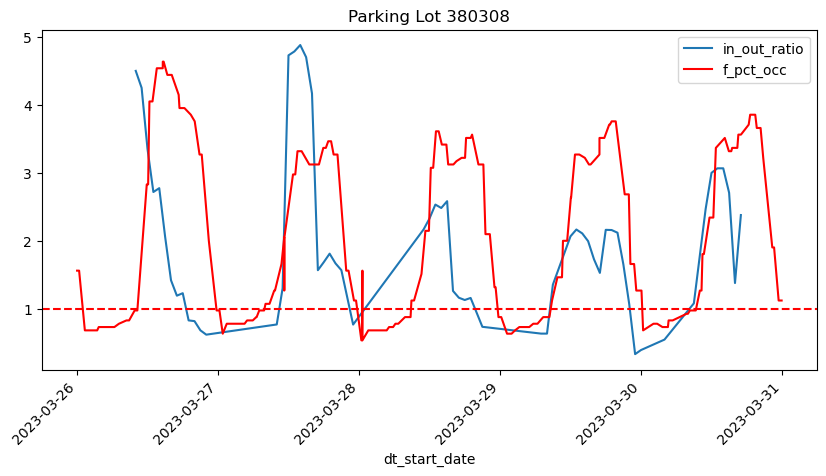

In [8]:
# establish time/place of interest
lot_id = 380308 # random.choice(lot_ids)
start_day = random.randint(1, 28)
end_day = random.randint(start_day + 1, min(start_day + 7, 31))
start_time = f'2023-03-{start_day} 00:00'
end_time = f'2023-03-{end_day} 00:00'
lot_df = hour_df[hour_df['pk_lot'] == lot_id].copy()
lot_df = lot_df[(lot_df['nearest_hour'] >= start_time) & (lot_df['nearest_hour'] <= end_time)]
occ_df = parking_occupancy[parking_occupancy['pk_lot'] == lot_id].copy()
occ_df = occ_df[(occ_df['dt_start_date'] >= start_time) & (occ_df['dt_start_date'] <= end_time)]
print(f'Parking lot {lot_id} from {start_time} to {end_time}')

# adjust columns to plot
lot_df['in_out_ratio'] = lot_df['in_out_ratio'].rolling(window=5, min_periods=1).mean()
max_rat = lot_df['in_out_ratio'].max()
occ_df['f_pct_occ'] = occ_df['f_pct_occ'] / 100 * max_rat

# plot
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
lot_df.plot(x='nearest_hour', y='in_out_ratio', ax=ax)
occ_df.plot(x='dt_start_date', y='f_pct_occ', ax=ax, color='red')
plt.axhline(y=1, color='r', linestyle='--')
plt.xticks(rotation=45)
plt.title(f'Parking Lot {lot_id}')
plt.show()


Best correlations:
- Parking lot 380308 from 2023-03-22 00:00 to 2023-03-26 00:00
- Parking lot 380308 from 2023-03-10 00:00 to 2023-03-14 00:00